In [1]:
import pandas as pd
import numpy as np
from tensorflow import one_hot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
df = pd.read_csv('HH_NSF_CMMI1759996_BuildingAssessments.csv')

In [3]:
x = df[['latitude', 'longitude', 'damage_indicator', 'building_address_sub_thoroughfare','year_built', 'first_floor_elevation', 'garage_door']]
y = df['overall_building_condition']

In [4]:
x = x.fillna(0)

In [5]:
x['year_built'] = x['year_built'].apply(lambda x: 2021 - x)

def door(door):
    if door == 'yes':
        return 1
    return 0

x['garage_door'] = x['garage_door'].apply(lambda variable: door(variable))

def thorough_cleaning(var):
    if not isinstance(var, int):
        return 0
    return var

x['building_address_sub_thoroughfare'] = x['building_address_sub_thoroughfare'].apply(lambda var: thorough_cleaning(var))

x['rand_features'] = np.random.randn(len(x))

In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# https://catalog.data.gov/dataset/tiger-line-shapefile-2017-state-texas-current-place-state-based

street_map = gpd.read_file('/Users/manikmukherjee/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
geometry = [Point(xy) for xy in zip(x["longitude"], x["latitude"])]

new = gpd.GeoDataFrame(geometry,columns=['geometry'])
new.crs = "EPSG:3081"
new.to_crs(epsg=3081, inplace=True)

street_map = street_map.iloc[15,:]
street_map = gpd.GeoSeries(street_map.geometry)

#find distance from all of the points to the shapfile in meters
x['dist_from_shore'] = new.geometry.apply(lambda x: street_map.boundary.distance(x))

In [7]:
y = one_hot(y,5)
y = y.numpy()

In [8]:
x_scaled = MinMaxScaler().fit_transform(x)

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=.2)

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, min_samples_leaf=2)
clf.fit(xtrain,ytrain)

prediction = clf.predict(xtest)
log_loss(prediction, ytest), accuracy_score(prediction,ytest)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(2.9270149489580572, 0.1652542372881356)

In [11]:
importances = list(zip(x.columns,clf.feature_importances_))
feature_importances = pd.DataFrame(importances,columns=['name','importance'])
feature_importances.sort_values(by=['importance'],ascending=False)

,name,importance
1,longitude,0.273578
4,year_built,0.238648
8,dist_from_shore,0.177528
0,latitude,0.146881
7,rand_features,0.071020
5,first_floor_elevation,0.059228
6,garage_door,0.028249
2,damage_indicator,0.004867
3,building_address_sub_thoroughfare,0.000000


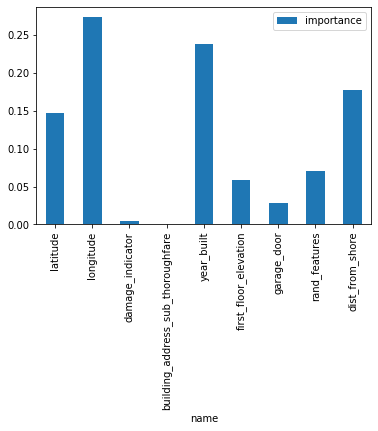

In [15]:
plot = feature_importances.plot.bar(x='name',y='importance')
plot.get_figure().savefig('harvey importances.png')